In [651]:
# example of a wgan for generating handwritten digits
from numpy import expand_dims
from numpy import mean
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from keras import backend
from tensorflow.keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import BatchNormalization
from keras.initializers import RandomNormal
from keras.constraints import Constraint
from matplotlib import pyplot
import pandas as pd
import numpy as np
import plotly.express as px 

In [652]:
df1 = pd.read_csv ("../Data/train.csv")
df = np.array(df1)[:,1:]
df = df[:, [0, 1]]
df, df.shape

(array([[0.01143886, 0.00269057],
        [0.00063166, 0.0072774 ],
        [0.01782796, 0.02821015],
        ...,
        [0.00768299, 0.00195759],
        [0.00339559, 0.00127959],
        [0.0045912 , 0.00667492]]),
 (745, 2))

In [653]:
# calculate wasserstein loss
def wasserstein_loss(y_true, y_pred):
	return backend.mean(y_true * y_pred)

In [654]:
def define_generator(G_in, dim=128, out_dim=2, lr=1e-5):
    x = Dense(dim)(G_in)
    x = Dense(dim*2,activation='sigmoid')(x)
    x = Dense(dim*4,activation='sigmoid')(x)
    G_out = Dense(out_dim)(x)
    G = Model(G_in, G_out)
    opt = RMSprop(lr=lr)
    G.compile(loss=wasserstein_loss, optimizer=opt)
    return G,G_out

G_in = Input(shape=[2])
G, G_out = define_generator(G_in)
G.summary()

Model: "model_109"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_121 (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dense_395 (Dense)            (None, 128)               384       
_________________________________________________________________
dense_396 (Dense)            (None, 256)               33024     
_________________________________________________________________
dense_397 (Dense)            (None, 512)               131584    
_________________________________________________________________
dense_398 (Dense)            (None, 2)                 1026      
Total params: 166,018
Trainable params: 166,018
Non-trainable params: 0
_________________________________________________________________


In [655]:
# define the standalone critic model
def define_critic(D_in,dim=128,out_dim=1,lr=1e-5):
	x = Dense(dim * 4)(D_in)
	x = Dropout(0.1)(x)
	x = Dense(dim * 2,activation='tanh')(x)
	x = Dropout(0.1)(x)
	x = Dense(dim,activation='tanh')(x)
	D_out = Dense(out_dim)(x)
	D = Model(D_in, D_out)
	opt = RMSprop(lr=lr)
	D.compile(loss=wasserstein_loss, optimizer=opt)
	return D,D_out

D_in = Input(shape=[2])
D, D_out = define_critic(D_in)
D.summary()

Model: "model_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_122 (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
dense_399 (Dense)            (None, 512)               1536      
_________________________________________________________________
dropout_78 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_400 (Dense)            (None, 256)               131328    
_________________________________________________________________
dropout_79 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_401 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_402 (Dense)            (None, 1)                 12

In [656]:
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def define_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss=wasserstein_loss, optimizer=G.optimizer)
    return GAN, GAN_out

GAN_in = Input([2])
GAN, GAN_out = define_gan(GAN_in, G, D)
GAN.summary()

Model: "model_111"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_123 (InputLayer)       [(None, 2)]               0         
_________________________________________________________________
model_109 (Functional)       (None, 2)                 166018    
_________________________________________________________________
model_110 (Functional)       (None, 1)                 165889    
Total params: 331,907
Trainable params: 166,018
Non-trainable params: 165,889
_________________________________________________________________


In [657]:
def train(GAN, G, D, epochs, batch_size=1,latent_dim=4,verbose=False):
    valid = -np.ones((batch_size, 1))
    fake = np.ones((batch_size, 1))
    clip_value = 0.01
    n_critic = 5
    e_range = range(epochs)
    f = open('../Logs/loss_logs.csv','w')
    f.write('Epoch,Discriminator Loss,Generator Loss\n')

    if verbose:
        e_range = tqdm(e_range)
    for epoch in e_range:
        for _ in range(n_critic):
            idx = np.random.randint(0, df.shape[0], batch_size)
            batch_data = df[idx]
                
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, latent_dim))

            # Generate a batch of new images
            gen_data = G.predict(noise)
            set_trainability(D, True)
            d_loss_real = D.train_on_batch(batch_data, valid)
            d_loss_fake = D.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)
            
            for l in D.layers:
                weights = l.get_weights()
                weights = [np.clip(w, -clip_value, clip_value) for w in weights]
                l.set_weights(weights)
        
        set_trainability(D, False)    
        g_loss = GAN.train_on_batch(noise, valid)

        # Plot the progress
        print ("%d [D loss: %f] [G loss: %f]" % (epoch,d_loss, g_loss))
        f.write("%d,%f,%f\n"%(epoch,d_loss,g_loss))

In [658]:
train(GAN, G, D, epochs=1000, batch_size=5,latent_dim=2,verbose=False)

0 [D loss: 0.000043] [G loss: -0.000087]
1 [D loss: 0.000043] [G loss: -0.000085]
2 [D loss: 0.000036] [G loss: -0.000083]
3 [D loss: 0.000036] [G loss: -0.000066]
4 [D loss: 0.000033] [G loss: -0.000082]
5 [D loss: 0.000028] [G loss: -0.000052]
6 [D loss: 0.000025] [G loss: -0.000045]
7 [D loss: 0.000015] [G loss: -0.000006]
8 [D loss: -0.000014] [G loss: 0.000030]
9 [D loss: -0.000031] [G loss: 0.000065]
10 [D loss: -0.000055] [G loss: 0.000108]
11 [D loss: -0.000083] [G loss: 0.000169]
12 [D loss: -0.000102] [G loss: 0.000218]
13 [D loss: -0.000128] [G loss: 0.000266]
14 [D loss: -0.000160] [G loss: 0.000326]
15 [D loss: -0.000184] [G loss: 0.000362]
16 [D loss: -0.000211] [G loss: 0.000437]
17 [D loss: -0.000230] [G loss: 0.000483]
18 [D loss: -0.000262] [G loss: 0.000534]
19 [D loss: -0.000283] [G loss: 0.000575]
20 [D loss: -0.000309] [G loss: 0.000624]
21 [D loss: -0.000338] [G loss: 0.000648]
22 [D loss: -0.000357] [G loss: 0.000714]
23 [D loss: -0.000378] [G loss: 0.000770]
24

# Loss plot

<AxesSubplot:>

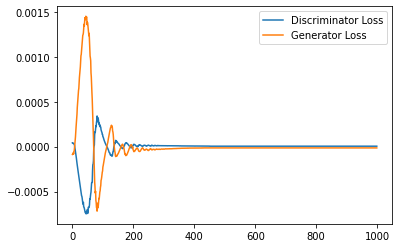

In [668]:
data = pd.read_csv('../Logs/loss_logs.csv')
data = data[['Discriminator Loss','Generator Loss']]
data.plot()

# True data

In [ ]:
test = np.random.normal(0, 1, size=[410, 2])
x =pd.DataFrame(G(test).numpy())
y= pd.DataFrame(df)

<AxesSubplot:>

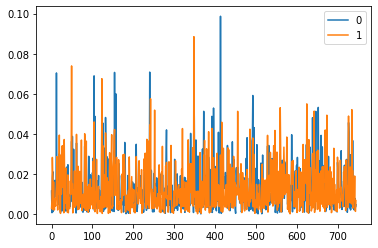

In [666]:
y.plot()

# Generated data

<AxesSubplot:>

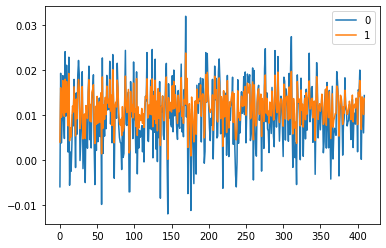

In [667]:
x.plot()